In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


In [6]:


from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import sys
sys.path.append("../")


from config import config
from utils.load_data import load_skin_data
from lesion_contraint_analyser import LesionConstraintsAnalyzer
import tensorflow as tf
from stratified_cross_validator import StratifiedCrossValidator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, VGG16, Xception, MobileNetV2

from tensorflow.keras import optimizers, callbacks
import time

from utils.load_data import load_skin_data
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from utils.utils import make_multimodal_dataset
from utils.data_preparation import handle_missing_values

2025-07-22 15:18:05.070478: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 15:18:05.074134: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 15:18:05.085142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753193885.102180   32548 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753193885.106880   32548 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753193885.120470   32548 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [7]:
import glob

paths = glob.glob("../results/histories/**/**/*.csv", recursive=True)


In [8]:
import matplotlib.pyplot as plt

def plot_metrics_from_df(df_results):
    plt.figure(figsize=(15, 3))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(df_results['accuracy'], label='Training Accuracy')
    plt.plot(df_results['val_accuracy'], label='Validation Accuracy')
    plt.title('Evolution of Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(df_results['loss'], label='Training Loss')
    plt.plot(df_results['val_loss'], label='Validation Loss')
    plt.title('Evolution of Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [9]:
#for path in paths:
    #print('--------------------------------------------')
    #print(path)
    #df = pd.read_csv(path)
    #plot_metrics_from_df(df)

In [141]:
d_eff = pd.read_csv("../results/histories/MultimodalEfficientNet/fold_1/history_fold_1.csv")

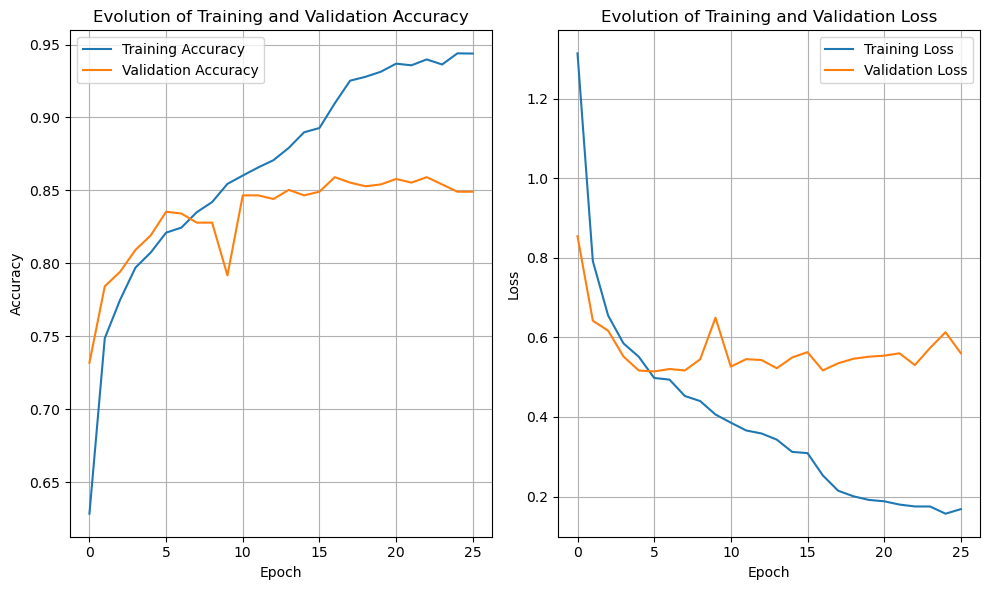

In [142]:
plt.figure(figsize=(10, 6))

    # Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(d_eff['accuracy'], label='Training Accuracy')
plt.plot(d_eff['val_accuracy'], label='Validation Accuracy')
plt.title('Evolution of Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

    # Loss plot
plt.subplot(1, 2, 2)
plt.plot(d_eff['loss'], label='Training Loss')
plt.plot(d_eff['val_loss'], label='Validation Loss')
plt.title('Evolution of Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig('../img/accurancyloss.eps')
plt.show()

In [12]:
paths2 = glob.glob("../results/models/**/*.keras")

In [13]:
paths2

['../results/models/fold_4/MultimodalMobileNet_fold_4_best.keras',
 '../results/models/fold_4/MultimodalEfficientNet_fold_4_best.keras',
 '../results/models/fold_4/MultimodalDenseNet_fold_4_best.keras',
 '../results/models/fold_0/MultimodalResNet_fold_0_best.keras',
 '../results/models/fold_0/MultimodalDenseNet_fold_0_best.keras',
 '../results/models/fold_0/MultimodalEfficientNet_fold_0_best.keras',
 '../results/models/fold_0/MultimodalXception_fold_0_best.keras',
 '../results/models/fold_0/MultimodalVGG_fold_0_best.keras',
 '../results/models/fold_0/MultimodalMobileNet_fold_0_best.keras',
 '../results/models/fold_1/MultimodalMobileNet_fold_1_best.keras',
 '../results/models/fold_1/MultimodalEfficientNet_fold_1_best.keras',
 '../results/models/fold_1/MultimodalResNet_fold_1_best.keras',
 '../results/models/fold_1/MultimodalXception_fold_1_best.keras',
 '../results/models/fold_1/MultimodalVGG_fold_1_best.keras',
 '../results/models/fold_1/MultimodalDenseNet_fold_1_best.keras',
 '../resu

In [14]:
import json

with open("../results/cross_val_index.json", 'r') as f:
    cross_vall = json.load(f)

In [15]:
from multimodal_cnn import MultimodalCNNFramework

In [16]:
import glob
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = '../data/'
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob.glob(os.path.join(base_skin_dir, 'HAM10000_images_part_*', '*.jpg'))
}
#Read File csv
df = pd.read_csv('../data/HAM10000_metadata.csv')
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [17]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../data/HAM10000_images_part_2/ISIC_0033084.jpg,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../data/HAM10000_images_part_2/ISIC_0033550.jpg,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../data/HAM10000_images_part_2/ISIC_0033536.jpg,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../data/HAM10000_images_part_2/ISIC_0032854.jpg,Actinic keratoses,0


In [18]:
mul_cnn = MultimodalCNNFramework(
        input_shape=(224, 224, 3), 
        num_classes=7, 
        batch_size=32, 
        epochs=15, 
        learning_rate=0.001
    )

2025-07-22 15:18:07.387915: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [19]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [20]:
import os
import joblib


def load_transformers(fold_number, save_dir='encoders'):
    path = f'{save_dir}/fold_{fold_number}/'
    label_encoder = joblib.load(os.path.join(path, f"{fold_number}_label_encoder.pkl"))
    onehot_encoder = joblib.load(os.path.join(path, f"{fold_number}_onehot_encoder.pkl"))
    scaler_age = joblib.load(os.path.join(path, f"{fold_number}_scaler_age.pkl"))
    
    X_test = pd.read_csv(os.path.join(path, f'X_test.csv' ))
    print('--------------- X_test shape', X_test.shape)
    return label_encoder, onehot_encoder, scaler_age, X_test



In [21]:
load_transformers(fold_number=2, save_dir='../results/encoders/')

--------------- X_test shape (2003, 10)


(LabelEncoder(),
 OneHotEncoder(handle_unknown='ignore', sparse_output=False),
 StandardScaler(),
         lesion_id      image_id     dx dx_type   age     sex     localization  \
 0     HAM_0000118  ISIC_0027419    bkl   histo  80.0    male            scalp   
 1     HAM_0002730  ISIC_0026769    bkl   histo  80.0    male            scalp   
 2     HAM_0002730  ISIC_0025661    bkl   histo  80.0    male            scalp   
 3     HAM_0001466  ISIC_0027850    bkl   histo  75.0    male              ear   
 4     HAM_0007207  ISIC_0031326    bkl   histo  65.0    male             back   
 ...           ...           ...    ...     ...   ...     ...              ...   
 1998  HAM_0006180  ISIC_0028990  akiec   histo  70.0    male  upper extremity   
 1999  HAM_0004282  ISIC_0033358  akiec   histo  65.0  female             face   
 2000  HAM_0000356  ISIC_0030655  akiec   histo  60.0  female             face   
 2001  HAM_0000020  ISIC_0031922  akiec   histo  60.0  female             face   


In [22]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image

def preprocess_fold(fold,  X_test_c = None,  base_skin_dir='../data/', encoders_dir='../results/encoders', input_size=(224,224)):
    
    label_encoder, sex_loc_encoder, age_scaler, X_test = load_transformers(fold_number=fold, save_dir=encoders_dir)
    
    if X_test_c is not None:
        X_test = X_test_c
    # Construction du dictionnaire image_id -> path
    imageid_path_dict = {
        os.path.splitext(os.path.basename(x))[0]: x
        for x in glob.glob(os.path.join(base_skin_dir, 'HAM10000_images_part_*', '*.jpg'))
    }
    X_test['path'] = X_test['image_id'].map(imageid_path_dict.get)

    df_clean = handle_missing_values(X_test[['path', 'sex', 'age', 'localization', 'dx']])

    df_clean['image'] = df_clean['path'].map(lambda x: np.asarray(Image.open(x).resize(input_size)))

    # Encodage métadonnées
    sex_loc_encoded = sex_loc_encoder.transform(df_clean[['sex', 'localization']])
    age_scaled = age_scaler.transform(df_clean[['age']])
    X_test_meta = np.concatenate([sex_loc_encoded, age_scaled], axis=1)

    # Encodage labels
    y_test_encoded = label_encoder.transform(df_clean['dx'])

    # Logs
    print(f"[Fold {fold}] X_test_meta shape: {X_test_meta.shape}")
    print(f"[Fold {fold}] y_test_encoded length: {len(y_test_encoded)}")

    return df_clean[['image']], X_test_meta, y_test_encoded, df_clean['dx'], X_test



In [23]:
def preprocess_image_with_pretrained(test_df, preprocess_func):

    # Stack les images (shape attendue : (N, H, W, 3))
    x_test = np.stack(test_df["image"].values)

    # Appliquer le prétraitement
    if preprocess_func:
        x_test = preprocess_func(x_test.astype(np.float32))

    return x_test

In [24]:

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xceptopn_preprocess





In [25]:
Xtest_origin = pd.DataFrame()

In [26]:
paths = glob.glob("../results/models/fold_1/*.keras")

In [27]:
def evaluate_on_test( model, test_data, y_true):


    y_pred_proba = model.predict(test_data)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    accurancy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accurancy, f1, mcc



In [28]:
results = {
    'EfficientNet': {
        'accuracy_score':[],
        'f1score': [],
         'matthews_corrcoef': []
    },
    'MobileNet': {
        'accuracy_score':[],
        'f1score': [],
        'matthews_corrcoef': []
    },
    'Xception': {
        'accuracy_score':[],
        'f1score': [],
        'matthews_corrcoef': []
    },
    'VGG': {
        'accuracy_score':[],
        'f1score': [],
        'matthews_corrcoef': []
    },
    'DenseNet': {
        'accuracy_score':[],
        'f1score': [],
        'matthews_corrcoef': []
    },
    'ResNet': {
        'accuracy_score':[],
        'f1score': [],
         'matthews_corrcoef': []
    },
    
}

In [29]:
NUMBER_OF_FOLDS = 5

In [30]:
import glob
'''
for fold in range(NUMBER_OF_FOLDS):
    X_images, X_metadata, y_test_encode, y_orin, Xtest_origin = preprocess_fold(fold)
    paths = glob.glob(f'../results/models/fold_{fold}/*.keras')
    for path in paths:
        if "EfficientNet" in path :
            pre_X_images = preprocess_image_with_pretrained(X_images, efficientnet_preprocess )
            
            test_data = make_multimodal_dataset( pre_X_images, X_metadata, y_test_encode,
                batch_size=32, shuffle=False, augment=False
            )
            model  = tf.keras.models.load_model(path)
            accuracy, f1score, matthews =   evaluate_on_test( model, test_data, y_test_encode)
            results['EfficientNet']['accuracy_score'].append(accuracy)
            results['EfficientNet']['f1score'].append(f1score)
            results['EfficientNet']['matthews_corrcoef'].append(matthews)
            
        elif "MobileNet" in path :
            pre_X_images = preprocess_image_with_pretrained(X_images, mobilenet_preprocess )
            
            test_data = make_multimodal_dataset( pre_X_images, X_metadata, y_test_encode,
                batch_size=32, shuffle=False, augment=False
            )
            model  = tf.keras.models.load_model(path)
            accuracy, f1score, matthews =   evaluate_on_test( model, test_data, y_test_encode)
            results['MobileNet']['accuracy_score'].append(accuracy)
            results['MobileNet']['f1score'].append(f1score)
            results['MobileNet']['matthews_corrcoef'].append(matthews)

        elif "VGG" in path:
            pre_X_images = preprocess_image_with_pretrained(X_images, vgg_preprocess )
            
            test_data = make_multimodal_dataset( pre_X_images, X_metadata, y_test_encode,
                batch_size=32, shuffle=False, augment=False
            )
            model  = tf.keras.models.load_model(path)
            accuracy, f1score, matthews =   evaluate_on_test( model, test_data, y_test_encode)
            results['VGG']['accuracy_score'].append(accuracy)
            results['VGG']['f1score'].append(f1score)
            results['VGG']['matthews_corrcoef'].append(matthews)
            
        elif "Xception" in path :
            pre_X_images = preprocess_image_with_pretrained(X_images, xceptopn_preprocess )
            
            test_data = make_multimodal_dataset( pre_X_images, X_metadata, y_test_encode,
                batch_size=32, shuffle=False, augment=False
            )
            model  = tf.keras.models.load_model(path)
            accuracy, f1score, matthews =   evaluate_on_test( model, test_data, y_test_encode)
            results['Xception']['accuracy_score'].append(accuracy)
            results['Xception']['f1score'].append(f1score)
            results['Xception']['matthews_corrcoef'].append(matthews)
        elif "DenseNet" in path: 
            pre_X_images = preprocess_image_with_pretrained(X_images, densenet_preprocess )
            
            test_data = make_multimodal_dataset( pre_X_images, X_metadata, y_test_encode,
                batch_size=32, shuffle=False, augment=False
            )
            model  = tf.keras.models.load_model(path)
            accuracy, f1score, matthews =   evaluate_on_test( model, test_data, y_test_encode)
            results['DenseNet']['accuracy_score'].append(accuracy)
            results['DenseNet']['f1score'].append(f1score)
            results['DenseNet']['matthews_corrcoef'].append(matthews)
        elif "ResNet" in path :
            pre_X_images = preprocess_image_with_pretrained(X_images, resnet_preprocess )
            
            test_data = make_multimodal_dataset( pre_X_images, X_metadata, y_test_encode,
                batch_size=32, shuffle=False, augment=False
            )
            model  = tf.keras.models.load_model(path)
            accuracy, f1score, matthews =   evaluate_on_test( model, test_data, y_test_encode)
            results['ResNet']['accuracy_score'].append(accuracy)
            results['ResNet']['f1score'].append(f1score)
            results['ResNet']['matthews_corrcoef'].append(matthews)
            
'''

'\nfor fold in range(NUMBER_OF_FOLDS):\n    X_images, X_metadata, y_test_encode, y_orin, Xtest_origin = preprocess_fold(fold)\n    paths = glob.glob(f\'../results/models/fold_{fold}/*.keras\')\n    for path in paths:\n        if "EfficientNet" in path :\n            pre_X_images = preprocess_image_with_pretrained(X_images, efficientnet_preprocess )\n            \n            test_data = make_multimodal_dataset( pre_X_images, X_metadata, y_test_encode,\n                batch_size=32, shuffle=False, augment=False\n            )\n            model  = tf.keras.models.load_model(path)\n            accuracy, f1score, matthews =   evaluate_on_test( model, test_data, y_test_encode)\n            results[\'EfficientNet\'][\'accuracy_score\'].append(accuracy)\n            results[\'EfficientNet\'][\'f1score\'].append(f1score)\n            results[\'EfficientNet\'][\'matthews_corrcoef\'].append(matthews)\n            \n        elif "MobileNet" in path :\n            pre_X_images = preprocess_image

In [31]:
results

{'EfficientNet': {'accuracy_score': [],
  'f1score': [],
  'matthews_corrcoef': []},
 'MobileNet': {'accuracy_score': [], 'f1score': [], 'matthews_corrcoef': []},
 'Xception': {'accuracy_score': [], 'f1score': [], 'matthews_corrcoef': []},
 'VGG': {'accuracy_score': [], 'f1score': [], 'matthews_corrcoef': []},
 'DenseNet': {'accuracy_score': [], 'f1score': [], 'matthews_corrcoef': []},
 'ResNet': {'accuracy_score': [], 'f1score': [], 'matthews_corrcoef': []}}

In [32]:
results = {'EfficientNet': {'accuracy_score': [0.8706939590614079,
   0.8622066899650525,
   0.8432351472790813,
   0.8652021967049426,
   0.8477284073889166],
  'f1score': [0.8688371058423013,
   0.8551190983692994,
   0.8411006154382581,
   0.8615960201006148,
   0.8467293622902656],
  'matthews_corrcoef': [0.7487232486165488,
   0.7262066826850695,
   0.696914845307349,
   0.7348708190024752,
   0.7065364382415056]},
 'MobileNet': {'accuracy_score': [0.6450324513230155,
   0.6749875187219171,
   0.6959560659011482,
   0.6475287069395906,
   0.6694957563654518],
  'f1score': [0.5770336051516871,
   0.6156827650034971,
   0.6235261283787772,
   0.5839251165752639,
   0.558493453715494],
  'matthews_corrcoef': [0.19930570615372203,
   0.3423895295884342,
   0.31336755523106774,
   0.2294943519112066,
   0.10953589283650855]},
 'Xception': {'accuracy_score': [0.689965052421368,
   0.7164253619570644,
   0.6929605591612581,
   0.6959560659011482],
  'f1score': [0.6347700894331906,
   0.6515226392612619,
   0.6153676644997683,
   0.6187923031224242],
  'matthews_corrcoef': [0.3080619769723649,
   0.3585736991207256,
   0.27785647914184497,
   0.27429827331114426]},
 'VGG': {'accuracy_score': [0.7573639540688967,
   0.7438841737393909,
   0.7583624563155267,
   0.7254118821767349],
  'f1score': [0.7136961669478105,
   0.7135896447050735,
   0.709611351971954,
   0.7065553766275218],
  'matthews_corrcoef': [0.5039309046382132,
   0.4772062494756299,
   0.4918668454848093,
   0.466660806746422]},
 'DenseNet': {'accuracy_score': [0.690963554667998,
   0.6704942586120819,
   0.6889665501747378,
   0.6934598102845732,
   0.6759860209685472],
  'f1score': [0.6309945522748794,
   0.5534066475799759,
   0.5979694082622095,
   0.6330380998004335,
   0.5812027793651543],
  'matthews_corrcoef': [0.31385499172498976,
   0.12132996604999931,
   0.23780999878087225,
   0.2919394542011396,
   0.24545419364235516]},
 'ResNet': {'accuracy_score': [0.8157763354967549,
   0.7883175237144283,
   0.7908137793310035,
   0.7863205192211683],
  'f1score': [0.8037712531469577,
   0.7641426609368852,
   0.7745854451438098,
   0.7493438659169083],
  'matthews_corrcoef': [0.6333238478051992,
   0.5791619912549769,
   0.5840583448487687,
   0.5573405213607789]}}

In [33]:

print(r"""\begin{table}
\centering
\caption{Accuracy, F1-score and MCC (mean ± standard deviation) obtained for each architecture on the skin cancer classification task.}
\begin{tabular}{p{4cm}p{3cm} p{3cm} p{3cm}}
\hline
Architecture & Accuracy & F1\_score & MCC \\
\hline""")

for model_name, metrics in results.items():
    acc_mean = np.mean(metrics['accuracy_score'])
    acc_std = np.std(metrics['accuracy_score'])
    
    f1_mean = np.mean(metrics['f1score'])
    f1_std = np.std(metrics['f1score'])
    
    mcc_mean = np.mean(metrics['matthews_corrcoef'])
    mcc_std = np.std(metrics['matthews_corrcoef'])

    print(f"{model_name} & ${acc_mean:.4f} \\pm {acc_std:.4f}$ & ${f1_mean:.4f} \\pm {f1_std:.4f}$ & ${mcc_mean:.4f} \\pm {mcc_std:.4f}$ \\\\")

print(r"""\hline
\end{tabular}
\label{tab:classification}
\end{table}""")


\begin{table}
\centering
\caption{Accuracy, F1-score and MCC (mean ± standard deviation) obtained for each architecture on the skin cancer classification task.}
\begin{tabular}{p{4cm}p{3cm} p{3cm} p{3cm}}
\hline
Architecture & Accuracy & F1\_score & MCC \\
\hline
EfficientNet & $0.8578 \pm 0.0105$ & $0.8547 \pm 0.0100$ & $0.7227 \pm 0.0188$ \\
MobileNet & $0.6666 \pm 0.0188$ & $0.5917 \pm 0.0244$ & $0.2388 \pm 0.0832$ \\
Xception & $0.6988 \pm 0.0104$ & $0.6301 \pm 0.0144$ & $0.3047 \pm 0.0338$ \\
VGG & $0.7463 \pm 0.0133$ & $0.7109 \pm 0.0030$ & $0.4849 \pm 0.0142$ \\
DenseNet & $0.6840 \pm 0.0090$ & $0.5993 \pm 0.0303$ & $0.2421 \pm 0.0667$ \\
ResNet & $0.7953 \pm 0.0119$ & $0.7730 \pm 0.0199$ & $0.5885 \pm 0.0278$ \\
\hline
\end{tabular}
\label{tab:classification}
\end{table}


In [34]:

X_images, X_metadata, y_test_encode, y_orin, Xtest_origin = preprocess_fold(0,  base_skin_dir='../data/', encoders_dir='../encoders')

pre_X_images = preprocess_image_with_pretrained(X_images, efficientnet_preprocess )
            
test_data = make_multimodal_dataset( pre_X_images, X_metadata, y_test_encode,
                batch_size=32, shuffle=False, augment=False
            )
model  = tf.keras.models.load_model("../Model_MultimodalEfficientNet_fold_0.keras")
accuracy, f1score, matthews =   evaluate_on_test( model, test_data, y_test_encode)

--------------- X_test shape (2003, 10)


[Fold 0] X_test_meta shape: (2003, 18)
[Fold 0] y_test_encoded length: 2003
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 823ms/step


In [35]:
print(accuracy)
print(f1score)
print(matthews)

0.8517224163754369
0.8510441759007321
0.715288439984673


In [36]:
Xtest_origin[["age",'sex', 'localization','path','cell_type']]

,age,sex,localization,path,cell_type
0,60.0,male,face,../data/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions
1,70.0,male,trunk,../data/HAM10000_images_part_2/ISIC_0032417.jpg,Benign keratosis-like lesions
2,75.0,male,upper extremity,../data/HAM10000_images_part_1/ISIC_0025915.jpg,Benign keratosis-like lesions
3,75.0,male,upper extremity,../data/HAM10000_images_part_2/ISIC_0031029.jpg,Benign keratosis-like lesions
4,75.0,male,upper extremity,../data/HAM10000_images_part_2/ISIC_0032128.jpg,Benign keratosis-like lesions
...,...,...,...,...,...
1998,60.0,male,face,../data/HAM10000_images_part_2/ISIC_0031108.jpg,Actinic keratoses
1999,45.0,male,trunk,../data/HAM10000_images_part_1/ISIC_0027334.jpg,Actinic keratoses
2000,65.0,female,face,../data/HAM10000_images_part_2/ISIC_0033151.jpg,Actinic keratoses
2001,55.0,female,face,../data/HAM10000_images_part_1/ISIC_0024948.jpg,Actinic keratoses


In [37]:
Xtest_origin.localization.unique()

array(['face', 'trunk', 'upper extremity', 'back', 'unknown', 'abdomen',
       'ear', 'chest', 'lower extremity', 'neck', 'scalp', 'hand', 'foot',
       'genital', 'acral'], dtype=object)

In [38]:
Xtest_origin

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,../data/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2
1,HAM_0001949,ISIC_0032417,bkl,histo,70.0,male,trunk,../data/HAM10000_images_part_2/ISIC_0032417.jpg,Benign keratosis-like lesions,2
2,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,../data/HAM10000_images_part_1/ISIC_0025915.jpg,Benign keratosis-like lesions,2
3,HAM_0001601,ISIC_0031029,bkl,histo,75.0,male,upper extremity,../data/HAM10000_images_part_2/ISIC_0031029.jpg,Benign keratosis-like lesions,2
4,HAM_0004884,ISIC_0032128,bkl,histo,75.0,male,upper extremity,../data/HAM10000_images_part_2/ISIC_0032128.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
1998,HAM_0004809,ISIC_0031108,akiec,histo,60.0,male,face,../data/HAM10000_images_part_2/ISIC_0031108.jpg,Actinic keratoses,0
1999,HAM_0004462,ISIC_0027334,akiec,histo,45.0,male,trunk,../data/HAM10000_images_part_1/ISIC_0027334.jpg,Actinic keratoses,0
2000,HAM_0004282,ISIC_0033151,akiec,histo,65.0,female,face,../data/HAM10000_images_part_2/ISIC_0033151.jpg,Actinic keratoses,0
2001,HAM_0004034,ISIC_0024948,akiec,histo,55.0,female,face,../data/HAM10000_images_part_1/ISIC_0024948.jpg,Actinic keratoses,0


In [39]:
pred = model.predict(test_data)

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 811ms/step


In [40]:
y_pred = np.argmax(pred, axis=1)
print('Accurancy', accuracy_score(y_test_encode, y_pred))
print("f1_score", accuracy_score(y_test_encode, y_pred))
print("mathe", matthews_corrcoef(y_test_encode, y_pred))

Accurancy 0.8517224163754369
f1_score 0.8517224163754369
mathe 0.715288439984673


In [41]:
from sklearn.metrics import confusion_matrix

def compute_tpr_fpr_per_group(y_true, y_pred, sensitive_features, n_classes):
    results = []

    for group in set(sensitive_features):
        indices = [i for i, s in enumerate(sensitive_features) if s == group]
        y_true_g = [y_true[i] for i in indices]
        y_pred_g = [y_pred[i] for i in indices]

        cm = confusion_matrix(y_true_g, y_pred_g, labels=range(n_classes))

        for class_idx in range(n_classes):
            tp = cm[class_idx, class_idx]
            fn = np.sum(cm[class_idx, :]) - tp
            fp = np.sum(cm[:, class_idx]) - tp
            tn = np.sum(cm) - (tp + fn + fp)

            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

            results.append({
                'Group': group,
                'Class': class_idx,
                'TPR': tpr,
                'FPR': fpr
            })

    df_results = pd.DataFrame(results)
    return df_results


In [42]:

def compute_tpr_fpr_per_group2(y_true, y_pred, sensitive_features):
    results = []

    classes = sorted(list(set(y_true) | set(y_pred)))

    for group in set(sensitive_features):
        indices = [i for i, s in enumerate(sensitive_features) if s == group]
        y_true_g = [y_true[i] for i in indices]
        y_pred_g = [y_pred[i] for i in indices]

        if len(y_true_g) == 0:
            continue  # Pas de données pour ce groupe

        cm = confusion_matrix(y_true_g, y_pred_g, labels=classes)

        for class_idx, class_label in enumerate(classes):
            tp = cm[class_idx, class_idx]
            fn = np.sum(cm[class_idx, :]) - tp
            fp = np.sum(cm[:, class_idx]) - tp
            tn = np.sum(cm) - (tp + fn + fp)

            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

            results.append({
                'Group': group,
                'Class': class_label,
                'TPR': tpr,
                'FPR': fpr
            })

    df_results = pd.DataFrame(results)
    return df_results


In [43]:
label_encoder, sex_loc_encoder, age_scaler, X_test = load_transformers(fold_number=0, save_dir="../encoders")

--------------- X_test shape (2003, 10)


In [44]:
y_true_without_encode = label_encoder.inverse_transform(y_test_encode)
y_pred_without_encode = label_encoder.inverse_transform(y_pred)

In [45]:
Xtest_origin.sex.unique()

array(['male', 'female'], dtype=object)

In [46]:

sensitive_features = Xtest_origin.sex
print("sensitive feature", sensitive_features.unique())
n_classes = 7
df_equity = compute_tpr_fpr_per_group2(y_pred_without_encode,y_true_without_encode , sensitive_features)
print(df_equity)


sensitive feature ['male' 'female']
     Group  Class       TPR       FPR
0     male  akiec  0.629630  0.011650
1     male    bcc  0.750000  0.014822
2     male    bkl  0.675926  0.049180
3     male     df  0.642857  0.003738
4     male    mel  0.630872  0.042781
5     male     nv  0.926254  0.145320
6     male   vasc  1.000000  0.004651
7   female  akiec  0.611111  0.008879
8   female    bcc  0.690476  0.005701
9   female    bkl  0.802198  0.031401
10  female     df  0.600000  0.001106
11  female    mel  0.651515  0.053927
12  female     nv  0.930370  0.106557
13  female   vasc  1.000000  0.002205


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


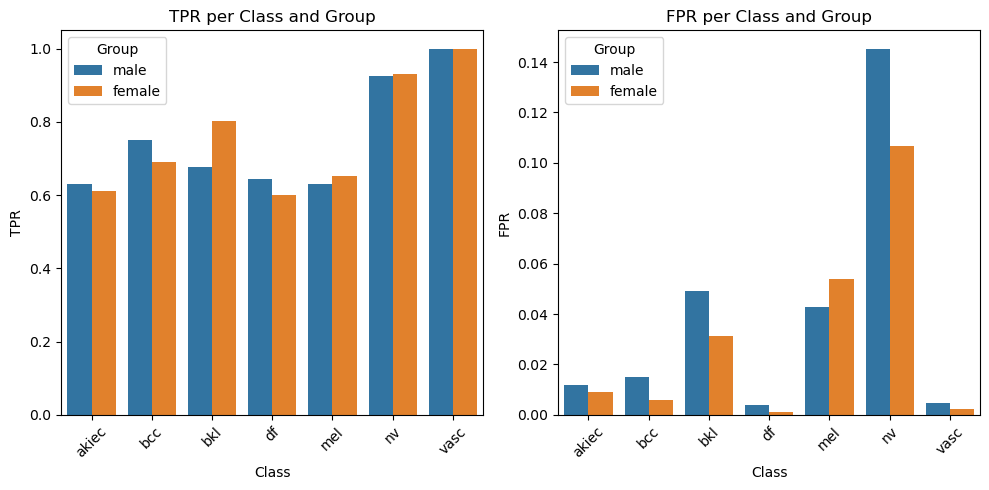

In [132]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

# Plot TPR
sns.barplot(data=df_equity, x='Class', y='TPR', hue='Group', ax=axes[0])
axes[0].set_title('TPR per Class and Group')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot FPR
sns.barplot(data=df_equity, x='Class', y='FPR', hue='Group', ax=axes[1])
axes[1].set_title('FPR per Class and Group')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig("group_fairness_equalized_odd.eps")

plt.show()


In [48]:
!pip install fairlearn


In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

y_true = y_test_encode  

def false_positive_rate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)
    TN = cm.sum() - (FP + cm.sum(axis=1) - np.diag(cm) + np.diag(cm))
    FPR = FP / (FP + TN)
    return np.mean(FPR)


metric_frame = MetricFrame(
    metrics = {
        'Accuracy': accuracy_score,
        'Recall (TPR)': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro'),
        'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro')
    },
    y_true = y_true,
    y_pred = y_pred,
    sensitive_features = sensitive_features
)


print("Métriques globales :")
print(metric_frame.overall)

print("\nMétriques par groupe sensible :")
print(metric_frame.by_group)


Métriques globales :
Accuracy        0.851722
Recall (TPR)    0.749335
Precision       0.753278
dtype: float64

Métriques par groupe sensible :
        Accuracy  Recall (TPR)  Precision
sex                                      
female  0.875952      0.767114   0.755096
male    0.831181      0.725117   0.750791


<Axes: title={'center': 'Métriques par groupe'}, xlabel='sex'>

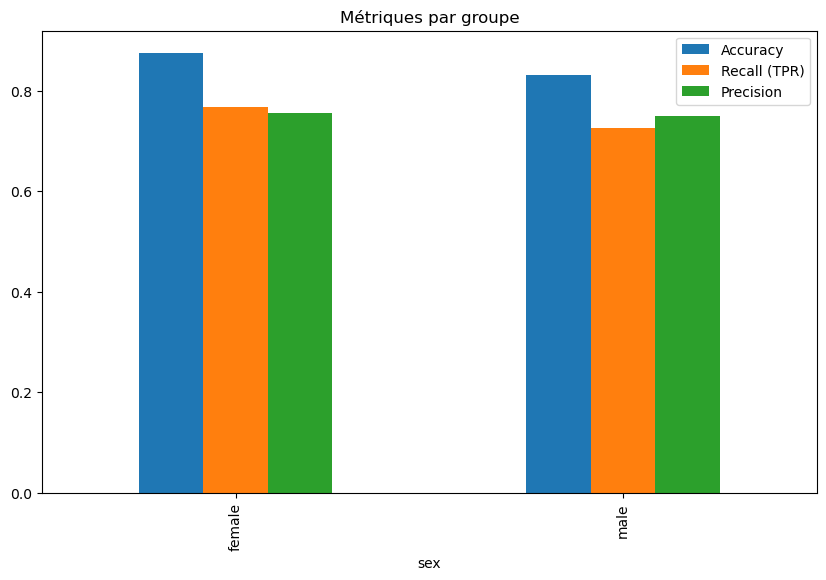

In [50]:
metric_frame.by_group.plot.bar(figsize=(10,6), title="Métriques par groupe")


# 2

In [51]:
from sklearn.metrics import confusion_matrix
import numpy as np

def fairness_multiclass_analysis(y_true, y_pred, sensitive_attr, class_names):
    results = {}
    
    for group in np.unique(sensitive_attr):
        mask = sensitive_attr == group
        cm = confusion_matrix(y_true[mask], y_pred[mask])
        
        # Précision par classe
        precision_per_class = np.diag(cm) / np.sum(cm, axis=0)
        # Rappel par classe  
        recall_per_class = np.diag(cm) / np.sum(cm, axis=1)
        
        results[group] = {
            'precision': dict(zip(class_names, precision_per_class)),
            'recall': dict(zip(class_names, recall_per_class)),
            'confusion_matrix': cm
        }
    
    return results

In [52]:
def multiclass_demographic_parity(y_true, y_pred, sensitive_attr):
    classes = np.unique(y_true)
    groups = np.unique(sensitive_attr)
    
    max_diff_per_class = []
    
    for cls in classes:
        rates = []
        for group in groups:
            mask = sensitive_attr == group
            rate = np.mean(y_pred[mask] == cls)
            rates.append(rate)
        
        # Différence max entre groupes pour cette classe
        max_diff = max(rates) - min(rates)
        max_diff_per_class.append(max_diff)
    
    return np.mean(max_diff_per_class)

In [53]:
def worst_case_fairness(y_true, y_pred, sensitive_attr):
    classes = np.unique(y_true)
    groups = np.unique(sensitive_attr)
    
    max_unfairness = 0
    
    for cls in classes:
        rates = []
        for group in groups:
            mask = (sensitive_attr == group) & (y_true == cls)
            if np.sum(mask) > 0:  # Éviter division par zéro
                rate = np.mean(y_pred[mask] == cls)
                rates.append(rate)
        
        if len(rates) > 1:
            unfairness = max(rates) - min(rates)
            max_unfairness = max(max_unfairness, unfairness)
    
    return max_unfairness

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_fairness_heatmap(results, metric='precision'):
    # Créer une matrice classe x groupe
    groups = list(results.keys())
    classes = list(results[groups[0]][metric].keys())
    
    matrix = np.zeros((len(classes), len(groups)))
    
    for i, cls in enumerate(classes):
        for j, group in enumerate(groups):
            matrix[i, j] = results[group][metric][cls]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, 
                xticklabels=groups, 
                yticklabels=classes,
                annot=True, 
                fmt='.3f',
                cmap='RdYlBu_r')
    plt.title(f'{metric.capitalize()} par classe et groupe')
    plt.xlabel('Groupes protégés')
    plt.ylabel('Classes')
    plt.show()

In [55]:
def evaluate_fairness_thresholds(results, thresholds={'precision': 0.05, 'recall': 0.05}):
    fairness_report = {}
    
    for metric, threshold in thresholds.items():
        max_diff = 0
        for cls in results[list(results.keys())[0]][metric].keys():
            values = [results[group][metric][cls] for group in results.keys()]
            diff = max(values) - min(values)
            max_diff = max(max_diff, diff)
        
        fairness_report[metric] = {
            'max_difference': max_diff,
            'is_fair': max_diff <= threshold,
            'threshold': threshold
        }
    
    return fairness_report

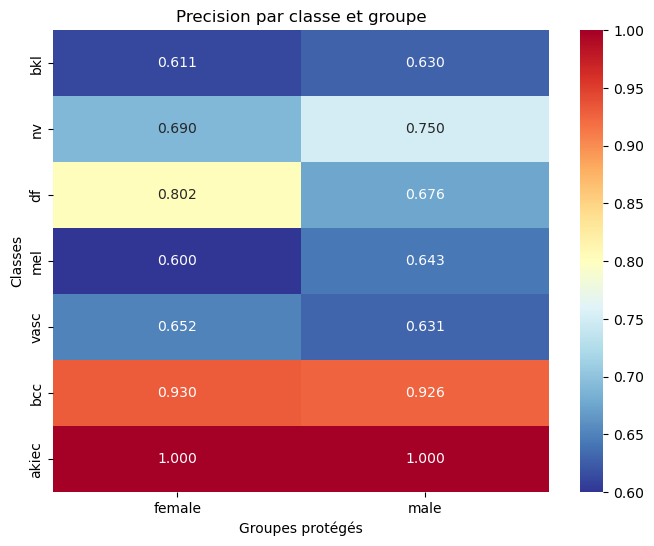

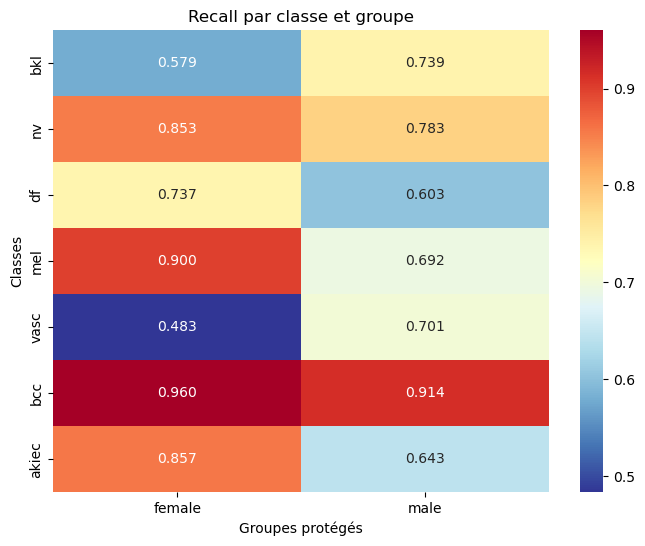

{'precision': {'max_difference': 0.1262718762718763, 'is_fair': False, 'threshold': 0.05}, 'recall': {'max_difference': 0.2183464698977025, 'is_fair': False, 'threshold': 0.05}}
Demographic Parity Score: 0.033
Worst Case Fairness Score: 0.218


In [56]:

class_names = df.dx.unique()

# Analyse complète
results = fairness_multiclass_analysis(y_true, y_pred, sensitive_features, class_names)

# Visualisation
plot_fairness_heatmap(results, 'precision')
plot_fairness_heatmap(results, 'recall')

# Évaluation des seuils
fairness_report = evaluate_fairness_thresholds(results)
print(fairness_report)

# Métriques agrégées
dp_score = multiclass_demographic_parity(y_true, y_pred, sensitive_features)
wc_score = worst_case_fairness(y_true, y_pred, sensitive_features)

print(f"Demographic Parity Score: {dp_score:.3f}")
print(f"Worst Case Fairness Score: {wc_score:.3f}")

In [59]:



def analyze_lesion_dataset(df):
    """Fonction principale pour analyser un dataset"""
    
    # Créer l'analyseur
    analyzer = LesionConstraintsAnalyzer(df)
    
    # Générer les contraintes
    constraints = analyzer.generate_constraints_dict()
    
    # Afficher le code Python
    analyzer.print_constraints_code()
    
    # Visualiser les distributions
    analyzer.plot_distributions()
    
    # Sauvegarder
    analyzer.save_constraints_to_file()
    
    return constraints

In [60]:
from CounterFactualGenerator import SkinCancerCounterfactualGenerator


def generate_cf_dataset(X_metadata,lesion_contrain, y_pred_classes, change='sex', target_classes=None):
    """
    Génère un dataset de contrefactuelles biologiquement valides
    
    Args:
        X_metadata: DataFrame avec colonnes ['age', 'sex', 'localization']
        y_pred_classes: array des classes prédites
        change: type de changement ('sex', 'age', 'location', 'mixed')
        target_classes: classes cibles pour les contrefactuelles (si None, utilise toutes)
    """
    generator = SkinCancerCounterfactualGenerator(lesion_type_dict= lesion_contrain)
    cf_rows = []
    
    if target_classes is None:
        target_classes = ['bkl', 'df', 'mel', 'vasc', 'bcc', 'nv', 'akiec']
    
    for idx, metadata_row in X_metadata.iterrows():
        original_class = y_pred_classes[idx]
        
        # Choisir une classe cible différente de l'originale
        possible_targets = [c for c in target_classes if c != original_class]
        if possible_targets:
            target_class = np.random.choice(possible_targets)
        else:
            target_class = original_class
            
        # Générer la contrefactuelle
        cf_metadata = generator.generate_counterfactual_metadata(
            metadata_row, target_class, change_type=change
        )
        cf_metadata['original_class'] = original_class
        cf_metadata['target_class'] = target_class
        
        cf_rows.append(cf_metadata)
    
    return pd.DataFrame(cf_rows)

In [61]:
Xtest_origin

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,../data/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2
1,HAM_0001949,ISIC_0032417,bkl,histo,70.0,male,trunk,../data/HAM10000_images_part_2/ISIC_0032417.jpg,Benign keratosis-like lesions,2
2,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,../data/HAM10000_images_part_1/ISIC_0025915.jpg,Benign keratosis-like lesions,2
3,HAM_0001601,ISIC_0031029,bkl,histo,75.0,male,upper extremity,../data/HAM10000_images_part_2/ISIC_0031029.jpg,Benign keratosis-like lesions,2
4,HAM_0004884,ISIC_0032128,bkl,histo,75.0,male,upper extremity,../data/HAM10000_images_part_2/ISIC_0032128.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
1998,HAM_0004809,ISIC_0031108,akiec,histo,60.0,male,face,../data/HAM10000_images_part_2/ISIC_0031108.jpg,Actinic keratoses,0
1999,HAM_0004462,ISIC_0027334,akiec,histo,45.0,male,trunk,../data/HAM10000_images_part_1/ISIC_0027334.jpg,Actinic keratoses,0
2000,HAM_0004282,ISIC_0033151,akiec,histo,65.0,female,face,../data/HAM10000_images_part_2/ISIC_0033151.jpg,Actinic keratoses,0
2001,HAM_0004034,ISIC_0024948,akiec,histo,55.0,female,face,../data/HAM10000_images_part_1/ISIC_0024948.jpg,Actinic keratoses,0



 GÉNÉRATION DES CONTRAINTES FINALES
 ANALYSE DES CONTRAINTES D'ÂGE

BKL (n=220):
  • Âge moyen: 65.5 ± 13.1
  • Plage recommandée: 45-85 ans
  • Plage complète: 0.0-85.0 ans

DF (n=23):
  • Âge moyen: 52.8 ± 13.3
  • Plage recommandée: 35-74 ans
  • Plage complète: 25.0-80.0 ans

MEL (n=223):
  • Âge moyen: 60.6 ± 16.0
  • Plage recommandée: 30-85 ans
  • Plage complète: 5.0-85.0 ans

VASC (n=28):
  • Âge moyen: 50.0 ± 22.4
  • Plage recommandée: 13-80 ans
  • Plage complète: 5.0-85.0 ans

BCC (n=103):
  • Âge moyen: 67.3 ± 13.7
  • Plage recommandée: 40-85 ans
  • Plage complète: 30.0-85.0 ans

NV (n=1341):
  • Âge moyen: 46.8 ± 15.5
  • Plage recommandée: 20-75 ans
  • Plage complète: 0.0-85.0 ans

AKIEC (n=65):
  • Âge moyen: 65.4 ± 13.0
  • Plage recommandée: 41-85 ans
  • Plage complète: 30.0-85.0 ans

 ANALYSE DES PRÉFÉRENCES DE SEXE

BKL (n=220):
  • Hommes: 121 (55.0%)
  • Femmes: 99 (45.0%)
  • Préférence: Aucune
  • Significatif: Non (p=0.138)

DF (n=23):
  • Hommes: 13 (56.

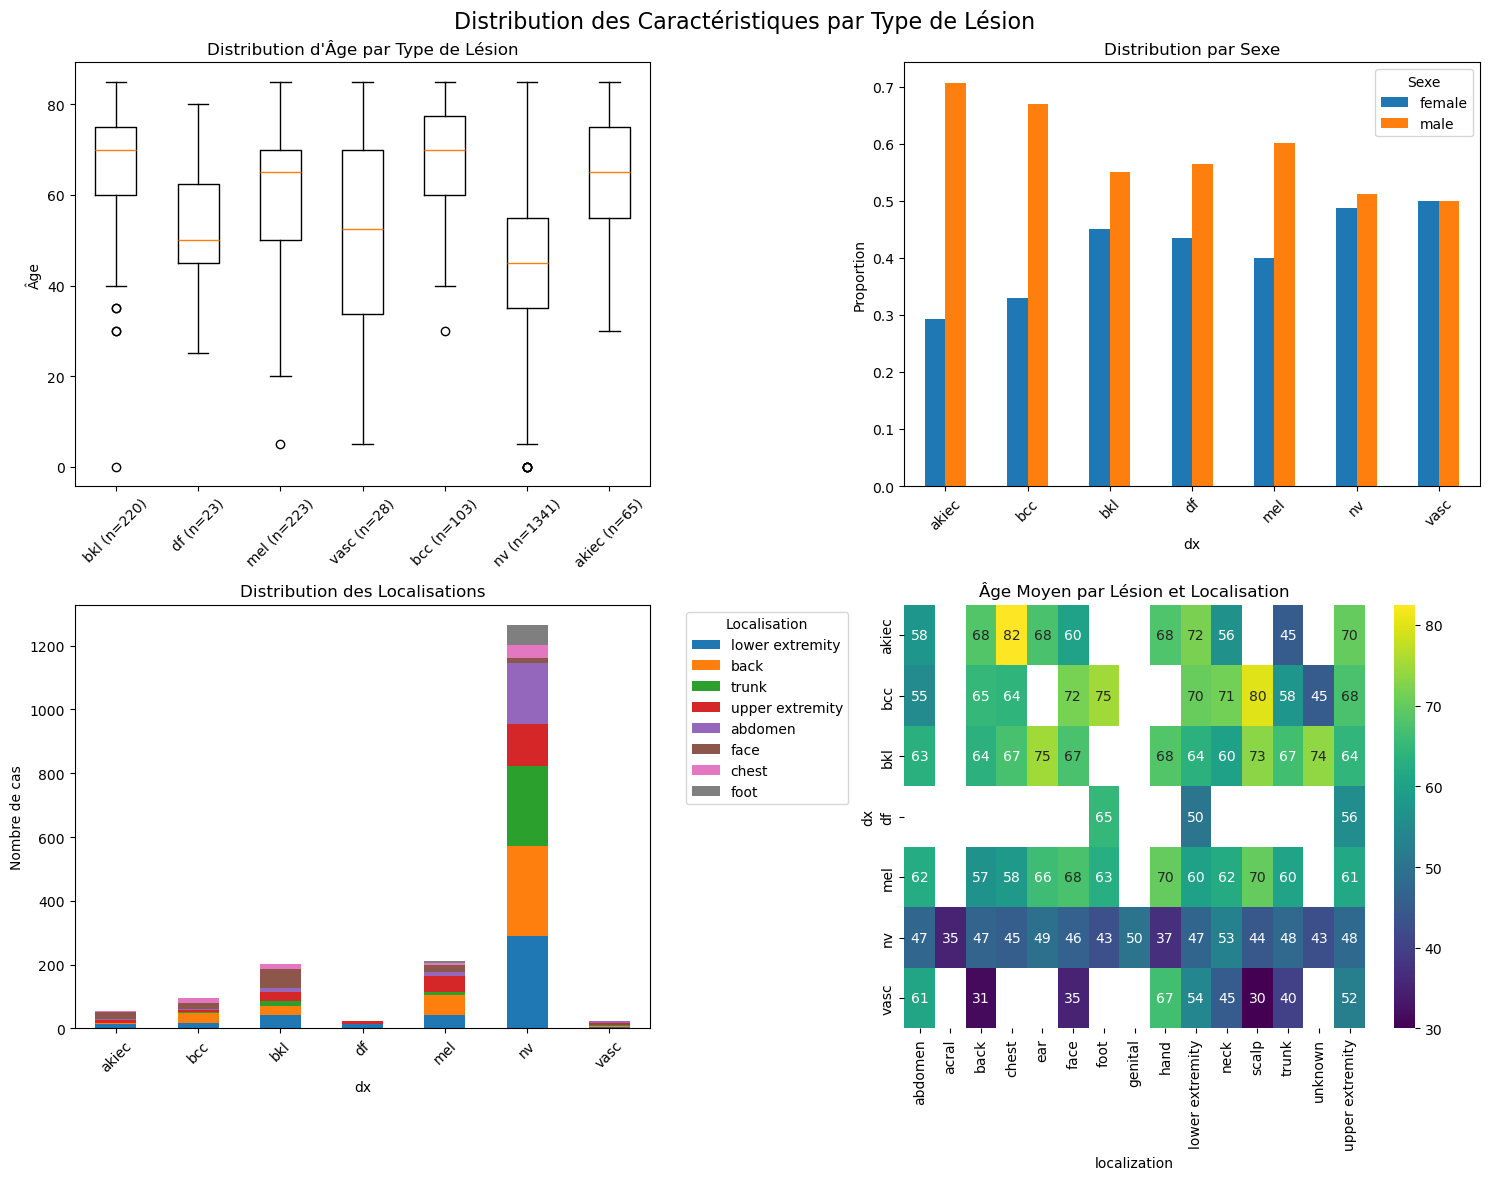

 Contraintes sauvegardées dans lesion_constraints.py


In [62]:
constraints = analyze_lesion_dataset(Xtest_origin)
cf_dataset = generate_cf_dataset(Xtest_origin, constraints,Xtest_origin["dx"], change='mixed')


In [63]:
cf_dataset

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,original_class,target_class
0,HAM_0002761,ISIC_0029176,bkl,histo,80.0,female,face,../data/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2,bkl,akiec
1,HAM_0001949,ISIC_0032417,bkl,histo,32.0,female,trunk,../data/HAM10000_images_part_2/ISIC_0032417.jpg,Benign keratosis-like lesions,2,bkl,vasc
2,HAM_0001601,ISIC_0025915,bkl,histo,75.0,female,lower extremity,../data/HAM10000_images_part_1/ISIC_0025915.jpg,Benign keratosis-like lesions,2,bkl,vasc
3,HAM_0001601,ISIC_0031029,bkl,histo,44.0,female,lower extremity,../data/HAM10000_images_part_2/ISIC_0031029.jpg,Benign keratosis-like lesions,2,bkl,df
4,HAM_0004884,ISIC_0032128,bkl,histo,60.0,female,upper extremity,../data/HAM10000_images_part_2/ISIC_0032128.jpg,Benign keratosis-like lesions,2,bkl,df
...,...,...,...,...,...,...,...,...,...,...,...,...
1998,HAM_0004809,ISIC_0031108,akiec,histo,71.0,female,upper extremity,../data/HAM10000_images_part_2/ISIC_0031108.jpg,Actinic keratoses,0,akiec,df
1999,HAM_0004462,ISIC_0027334,akiec,histo,45.0,female,lower extremity,../data/HAM10000_images_part_1/ISIC_0027334.jpg,Actinic keratoses,0,akiec,vasc
2000,HAM_0004282,ISIC_0033151,akiec,histo,65.0,male,back,../data/HAM10000_images_part_2/ISIC_0033151.jpg,Actinic keratoses,0,akiec,mel
2001,HAM_0004034,ISIC_0024948,akiec,histo,55.0,male,trunk,../data/HAM10000_images_part_1/ISIC_0024948.jpg,Actinic keratoses,0,akiec,bkl


In [64]:
df_cf = cf_dataset[['age','sex','localization','path','image_id', 'dx']]

In [ ]:
X_images_cf, X_metadata_cf, y_test_encode, y_orin, Xtest_cf = preprocess_fold(0, df_cf)
pre_X_images = preprocess_image_with_pretrained(X_images_cf, efficientnet_preprocess )
test_data_cf = make_multimodal_dataset( pre_X_images, X_metadata_cf, y_test_encode,
                batch_size=32, shuffle=False, augment=False
            )
print(" ------------------finale dataset shape", len(test_data_cf))
print(test_data_cf)

--------------- X_test shape (2003, 10)
[Fold 0] X_test_meta shape: (2003, 18)
[Fold 0] y_test_encoded length: 2003
 ------------------finale dataset shape 63
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [66]:
pred_cf = model.predict(test_data_cf)

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 795ms/step


In [67]:
y_pred_cf = np.argmax(pred_cf, axis=1)
print('Accurancy', accuracy_score(y_test_encode, y_pred_cf))
print("f1_score", accuracy_score(y_test_encode, y_pred_cf))
print("mathe", matthews_corrcoef(y_test_encode, y_pred_cf))

Accurancy 0.8077883175237144
f1_score 0.8077883175237144
mathe 0.6314314418487678


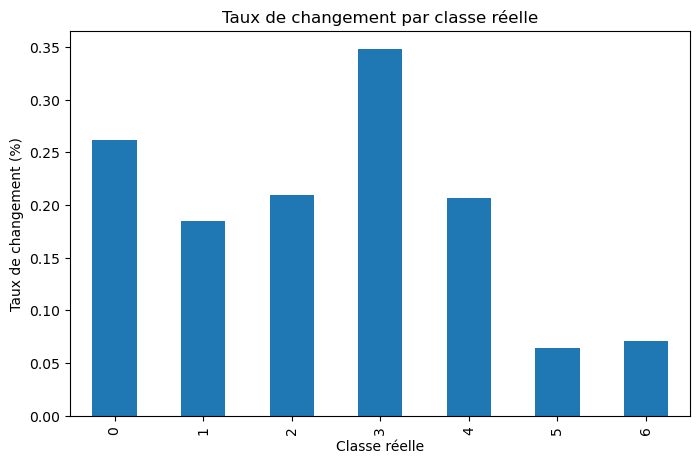

In [68]:
import pandas as pd

df = pd.DataFrame({
    'y_true': y_true,
    'initial_pred': y_pred,
    'cf_pred': y_pred_cf
})
df['changed'] = df['initial_pred'] != df['cf_pred']

change_rate_per_true_class = df.groupby('y_true')['changed'].mean()

change_rate_per_true_class.plot(kind='bar', figsize=(8,5), title='Taux de changement par classe réelle')
plt.ylabel('Taux de changement (%)')
plt.xlabel('Classe réelle')
plt.show()


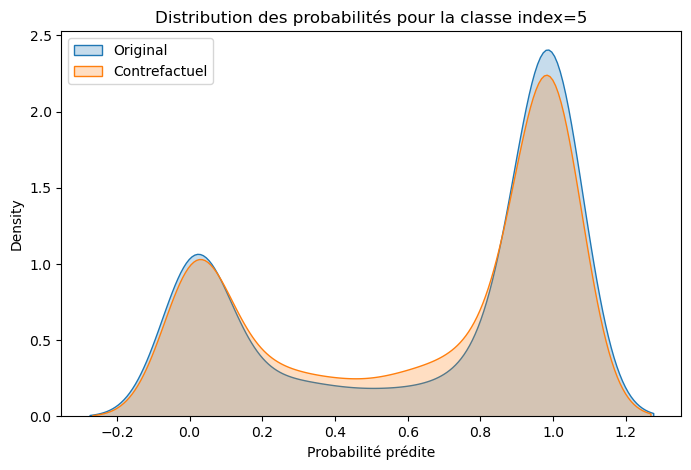

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

classe_idx = 5  # exemple : index de la classe 'mel'

plt.figure(figsize=(8,5))
sns.kdeplot(pred[:, classe_idx], label='Original', fill=True)
sns.kdeplot(pred_cf[:, classe_idx], label='Contrefactuel', fill=True)
plt.title(f'Distribution des probabilités pour la classe index={classe_idx}')
plt.xlabel('Probabilité prédite')
plt.legend()
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


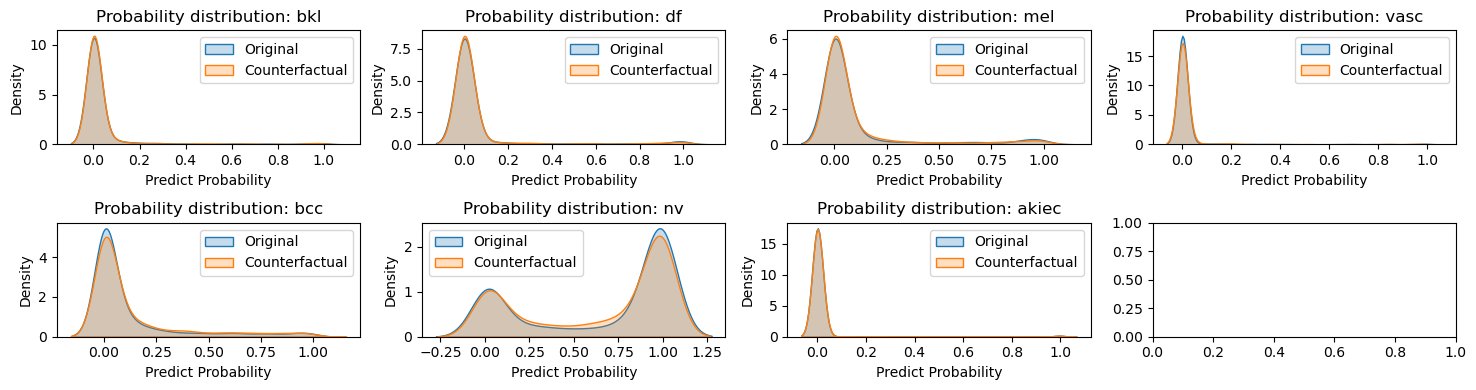

In [130]:
classes = ['bkl', 'df', 'mel', 'vasc', 'bcc', 'nv', 'akiec']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,4))
axes = axes.flatten()

for idx, classe in enumerate(classes):
    sns.kdeplot(pred[:, idx], label='Original', fill=True, ax=axes[idx])
    sns.kdeplot(pred_cf[:, idx], label='Counterfactual', fill=True, ax=axes[idx])
    axes[idx].set_title(f'Probability distribution: {classe}')
    axes[idx].set_xlabel('Predict Probability')
    axes[idx].legend()

plt.tight_layout()
plt.savefig("probability_countefactual_evaluation.eps")

plt.show()


In [87]:


cf_gap_per_class = np.abs(pred - pred_cf).mean(axis=0)

cf_gap_df = pd.DataFrame({
    'Classe': classes,
    'CF_Gap_Moyen': cf_gap_per_class
})

print(cf_gap_df)


  Classe  CF_Gap_Moyen
0    bkl      0.014746
1     df      0.018008
2    mel      0.043643
3   vasc      0.009663
4    bcc      0.047254
5     nv      0.085085
6  akiec      0.001768


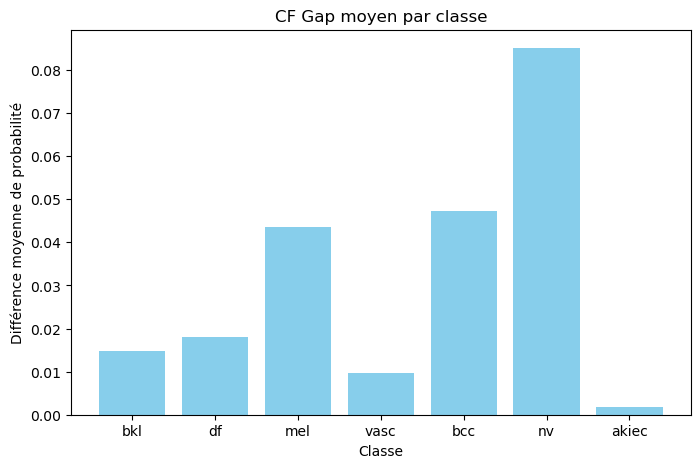

In [72]:
plt.figure(figsize=(8,5))
plt.bar(cf_gap_df['Classe'], cf_gap_df['CF_Gap_Moyen'], color='skyblue')
plt.title("CF Gap moyen par classe")
plt.ylabel("Différence moyenne de probabilité")
plt.xlabel("Classe")
plt.show()


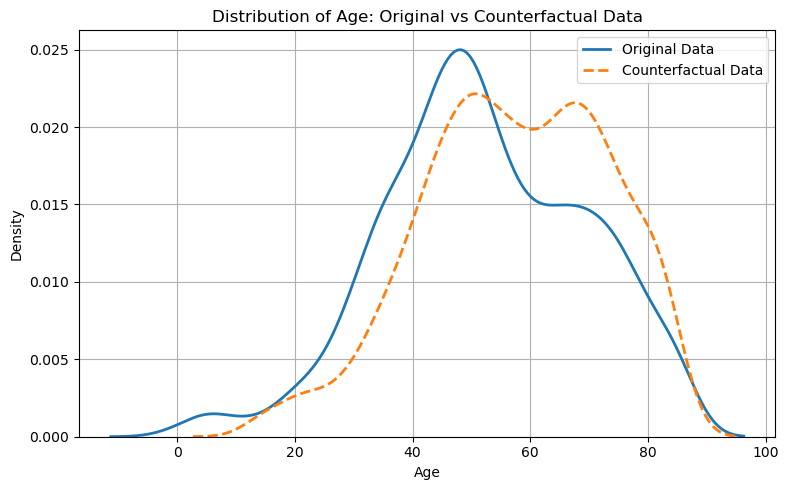

In [94]:

plt.figure(figsize=(8, 5))

sns.kdeplot(data=Xtest_origin, x='age', label='Original Data', linewidth=2)
sns.kdeplot(data=Xtest_cf, x='age', label='Counterfactual Data', linewidth=2, linestyle='--')

plt.title('Distribution of Age: Original vs Counterfactual Data')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
y_pred_cf_init = label_encoder.inverse_transform(y_pred_cf)

In [111]:

sensitive_features_cf = Xtest_cf.sex
print("sensitive feature", sensitive_features_cf.unique())
n_classes = 7
df_equity2 = compute_tpr_fpr_per_group2(y_true_without_encode,y_pred_cf_init , sensitive_features_cf)
print(df_equity2)



sensitive feature ['female' 'male']
     Group  Class       TPR       FPR
0     male  akiec  0.484848  0.020106
1     male    bcc  0.607843  0.014024
2     male    bkl  0.587629  0.027242
3     male     df  0.615385  0.008290
4     male    mel  0.537736  0.064220
5     male     nv  0.917788  0.216828
6     male   vasc  0.888889  0.000000
7   female  akiec  0.718750  0.018127
8   female    bcc  0.826923  0.020555
9   female    bkl  0.536585  0.036585
10  female     df  0.600000  0.007882
11  female    mel  0.632479  0.056167
12  female     nv  0.895833  0.192635
13  female   vasc  0.684211  0.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


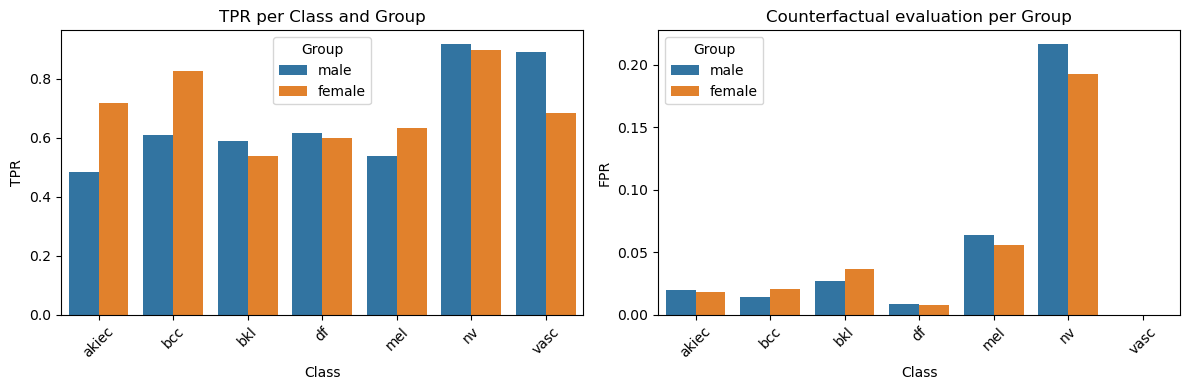

In [134]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

# Plot TPR
sns.barplot(data=df_equity2, x='Class', y='TPR', hue='Group', ax=axes[0])
axes[0].set_title('TPR per Class and Group')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot FPR
sns.barplot(data=df_equity2, x='Class', y='FPR', hue='Group', ax=axes[1])
axes[1].set_title('FPR per Class and Group')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.title('Counterfactual evaluation per Group')
plt.savefig("group_countefactual_evaluation.eps")
plt.show()
